In [1]:
import pandas as pd
import itertools
import collections
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# set some nicer defaults for matplotlib
from matplotlib import rcParams

We import a cleaned version of manually annotated edit filters:

In [2]:
df = pd.read_csv("20190106115600_filters-sorted-by-hits-manual-tags.csv", sep='\t')

As well as an orignial query against the abuse_filter table:

In [3]:
df_origin = pd.read_csv("quarry-32518-all-filters-sorted-num-hits.csv", sep=',')

## General stats

In [90]:
# Number of filters
len(df)

954

In [16]:
# Active (enabled) filters
num_enabled = len(df.query('af_enabled==1'))
print (num_enabled)

# Disabled filters
num_disabled = len(df.query('af_enabled==0'))
print (num_disabled)

# Deleted filters
num_deleted = len(df.query('af_deleted==1'))
print (num_deleted)

# Deleted and enabled -- make sure it's 0 
num_enabled_deleted = len(df.query('af_deleted==1 and af_enabled==1'))
print (num_enabled_deleted)

201
753
600
0


In [17]:
# public filters
num_public = len(df.query('af_hidden==0'))
print (num_public)

# Active public filters
num_enabled_public = len(df.query('af_hidden==0 and af_enabled==1'))
print (num_enabled_public)

# disabled (but not deleted) public filters
num_disabled_public = len(df.query('af_hidden==0 and af_enabled==0 and af_deleted==0'))
print (num_disabled_public)

# deleted public filters
num_deleted_public = num_public - num_enabled_public - num_disabled_public
print (num_deleted_public)

361
110
35
216


In [15]:
# hidden filters
num_hidden = len(df.query('af_hidden==1'))
print (num_hidden)

# active hidden filters
num_enabled_hidden = len(df.query('af_hidden==1 and af_enabled==1'))
print (num_enabled_hidden)

# disabled (but not deleted) hidden filters
num_disabled_hidden = len(df.query('af_hidden==1 and af_enabled==0 and af_deleted==0'))
print (num_disabled_hidden)

# deleted hidden filters
num_deleted_hidden = num_hidden - num_enabled_hidden - num_disabled_hidden
print (num_deleted_hidden)

593
91
118
384


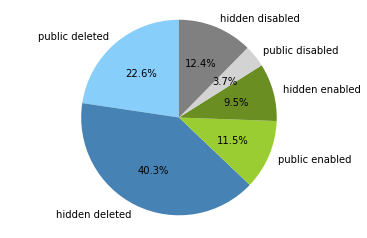

In [25]:
# plot general overview

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# here, we mean "disabled, but not deleted"
labels = ['public deleted', 'hidden deleted', 'public enabled', 'hidden enabled', 'public disabled', 'hidden disabled']
sizes = [num_deleted_public, num_deleted_hidden, num_enabled_public, num_enabled_hidden, num_disabled_public, num_disabled_hidden]


fig1, ax1 = plt.subplots()
ax1.set_prop_cycle(color=['lightskyblue', 'steelblue', 'yellowgreen', 'olivedrab', 'lightgrey', 'grey'])
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.show()

In [105]:
# global filters
print (len(df.query('af_global==0')))

954


In [5]:
# throttled
print (len(df.query('af_throttled==0')))

print (len(df.query('af_throttled==1')))

948
6


In [9]:
# group
print (len(df.query('af_group=="default"')))
print (df.query('af_group!="default"'))

# --> so available groups are "default" and "feedback"
# TODO: question: what do they mean?
# From https://www.mediawiki.org/wiki/Extension:AbuseFilter/abuse_filter_table :
# "The group this filter belongs to, as defined in $wgAbuseFilterValidGroups." still don't get it

947
     Unnamed: 0  af_id  af_hidden  af_global  af_enabled  af_deleted  \
168         168    497          0          0           0           1   
173         173    494          0          0           0           1   
174         174    502          0          0           0           1   
187         187    495          0          0           0           1   
190         190    496          0          0           0           1   
227         227    475          0          0           0           1   
349         349    461          0          0           0           1   

     af_throttled  af_group    af_timestamp af_actions  af_hit_count  \
168             0  feedback  20130108151106   disallow          3660   
173             0  feedback  20130108151035   disallow          3325   
174             0  feedback  20130424011002   disallow          3280   
187             0  feedback  20130108151045   disallow          2697   
190             0  feedback  20130108151054   disallow     

In [5]:
# filter hits per month (all filters) (data quarry from 05.03.2019, that's why hitcount Mar 2019 is so small)
df_hits = pd.read_csv("quarry-34014-how-many-abuse-filter-hits-have-been-there-per-month-en-wiki-run346197.csv", sep=',')
df_hits['LogMonth'] = pd.to_datetime(df_hits['LogMonth'], format="%Y%m")

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_hits)


      LogMonth    Freq
0   2019-03-01   34309
1   2019-02-01  236606
2   2019-01-01  252668
3   2018-12-01  226287
4   2018-11-01  253233
5   2018-10-01  256438
6   2018-09-01  230354
7   2018-08-01  216045
8   2018-07-01  205477
9   2018-06-01  209374
10  2018-05-01  238235
11  2018-04-01  242857
12  2018-03-01  255431
13  2018-02-01  213548
14  2018-01-01  235705
15  2017-12-01  213359
16  2017-11-01  254671
17  2017-10-01  224244
18  2017-09-01  212790
19  2017-08-01  195593
20  2017-07-01  176778
21  2017-06-01  184406
22  2017-05-01  231250
23  2017-04-01  225176
24  2017-03-01  257081
25  2017-02-01  246199
26  2017-01-01  256925
27  2016-12-01  226680
28  2016-11-01  258655
29  2016-10-01  254070
30  2016-09-01  238406
31  2016-08-01  192681
32  2016-07-01  171567
33  2016-06-01  201867
34  2016-05-01  294276
35  2016-04-01  319474
36  2016-03-01  360327
37  2016-02-01  366637
38  2016-01-01  372907
39  2015-12-01  307003
40  2015-11-01  338129
41  2015-10-01  264966
42  2015-09

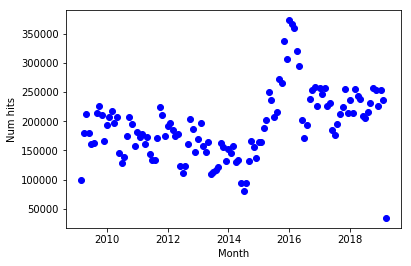

In [9]:
plt.xlabel('Month')
plt.ylabel('Num hits')
plt.plot(df_hits['LogMonth'],df_hits['Freq'], 'bo')
plt.show()

## Helper functions

In [7]:
flatten = lambda x: list(itertools.chain.from_iterable(x))

## Edit filter actions

In [9]:
actions = df['af_actions'].fillna('log only')
actions_list = flatten([x.split(",") for x in list(actions)])
all_actions = collections.Counter(actions_list).most_common()

print(all_actions)

[('log only', 413), ('disallow', 406), ('warn', 122), ('tag', 70), ('throttle', 52), ('blockautopromote', 4)]


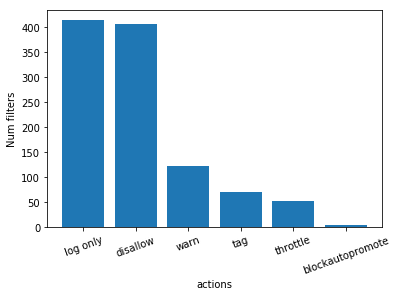

In [12]:
all_actions_labels = [x[0] for x in all_actions]
all_actions_values = [x[1] for x in all_actions]

plt.xlabel('actions')
plt.xticks(rotation='20')
plt.ylabel('Num filters')
plt.bar(all_actions_labels, all_actions_values)
plt.show()

In [13]:
# What are the actions of active hidden filters
active_hidden = df.query('af_hidden==1 and af_enabled==1')
active_hidden_actions = collections.Counter(list(active_hidden['af_actions'].fillna('log only'))).most_common()
print (active_hidden_actions)

[('disallow', 51), ('log only', 19), ('throttle,disallow', 7), ('throttle', 4), ('tag', 3), ('warn,tag', 2), ('throttle,warn', 2), ('warn', 1), ('disallow,tag', 1), ('warn,disallow', 1)]


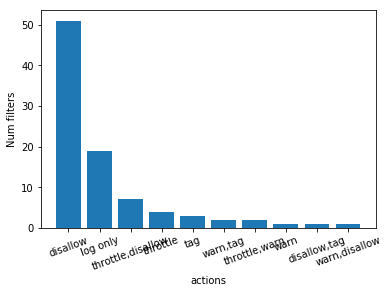

In [14]:
ah_actions_labels = [x[0] for x in active_hidden_actions]
ah_actions_values = [x[1] for x in active_hidden_actions]

plt.xlabel('actions')
plt.xticks(rotation='20')
plt.ylabel('Num filters')
plt.bar(ah_actions_labels, ah_actions_values)
plt.show()

In [16]:
# What are the actions of active public filters
active_public = df.query('af_hidden==0 and af_enabled==1')
active_public_actions = collections.Counter(list(active_public['af_actions'].fillna('log only'))).most_common()
print(active_public_actions)

[('tag', 25), ('warn,tag', 25), ('disallow', 22), ('log only', 20), ('warn', 12), ('throttle,tag', 2), ('warn,disallow', 2), ('throttle,warn,tag', 1), ('throttle,disallow', 1)]


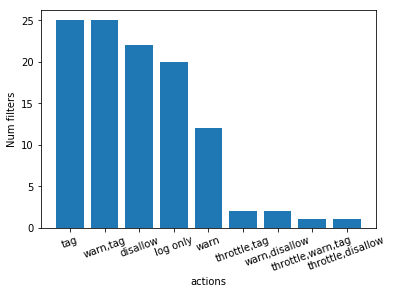

In [17]:
ap_actions_labels = [x[0] for x in active_public_actions]
ap_actions_values = [x[1] for x in active_public_actions]

plt.xlabel('actions')
plt.xticks(rotation='20')
plt.ylabel('Num filters')
plt.bar(ap_actions_labels, ap_actions_values)
plt.show()

In [18]:
# all ids of active public filters set to disallow
active_public[active_public['af_actions'].fillna('log only').str.contains('disallow')]

,Unnamed: 0,af_id,af_hidden,af_global,af_enabled,af_deleted,af_throttled,af_group,af_timestamp,af_actions,af_hit_count,af_public_comments,manual_tags,notes
3,3,384,0,0,1,0,0,default,20181018171832,disallow,1159239,Addition of bad words or other vandalism,vandalism,NaN
12,12,225,0,0,1,0,0,default,20180807154519,disallow,482872,Vandalism in all caps,vandalism,NaN
19,19,46,0,0,1,0,0,default,20181023193500,disallow,356945,"""Poop"" vandalism",vandalism,NaN
22,22,260,0,0,1,0,0,default,20181130204255,disallow,286852,Common vandal phrases,vandalism,NaN
37,37,320,0,0,1,0,0,default,20181023193636,disallow,152994,"""Your mom"" Vandalism",vandalism,NaN
41,41,12,0,0,1,0,0,default,20170606215509,disallow,122756,Replacing a page with obscenities,vandalism,NaN
47,47,680,0,0,1,0,0,default,20181023195329,disallow,95242,Adding emoji unicode characters,good_faith,NaN
54,54,365,0,0,1,0,0,default,20181023193820,disallow,85470,Unusual changes to featured or good content,vandalism,Unusual == unusually big (edit_delta > 15000 |...
67,67,803,0,0,1,0,0,default,20181023223916,disallow,46756,Prevent new users from editing other's user pages,"vandalism, good_faith",NaN
99,99,782,0,0,1,0,0,default,20181023223745,disallow,16702,Content Translation Edits,misc,why is this not allowed? Seems to be translati...


In [22]:
# Which actions were triggered how often over the years
df_actions = pd.read_csv("quarry-34047-number-of-abuse-filters-filter-actions-per-month-en-wiki-run346492.csv", sep=',')
df_actions.fillna('log')

,LogMonth,FilterActions,Freq
0,201903,log,14103
1,201903,disallow,9430
2,201903,tag,13283
3,201903,warn,6001
4,201902,log,73101
5,201902,disallow,47242
6,201902,"disallow,tag",8
7,201902,tag,81279
8,201902,warn,34976
9,201901,log,81745


In [2]:
# Which editors' actions triggered a filter
df_ed_actions = pd.read_csv("quarry-34050-which-actions-triggered-an-abuse-filter-en-wiki-run346498.csv", sep=',')
df_ed_actions

,LogMonth,EditorActions,Freq
0,201903,autocreateaccount,47
1,201903,createaccount,4780
2,201903,delete,5
3,201903,edit,37950
4,201903,move,84
5,201903,upload,3
6,201902,autocreateaccount,454
7,201902,createaccount,25204
8,201902,delete,5
9,201902,edit,210488


In [3]:
# In which namespaces did a filter trigger occur?
df_namespaces = pd.read_csv("quarry-34072-edits-in-which-namespaces-actions-triggered-an-abuse-filter-en-wiki-run346852.csv", sep=',')
df_namespaces

,LogMonth,Namespace,Freq
0,201903,-1,5177
1,201903,0,37653
2,201903,1,200
3,201903,2,1636
4,201903,3,604
5,201903,4,159
6,201903,5,13
7,201903,6,7
8,201903,10,98
9,201903,11,8


## Manual tags

In [39]:
manual_tags = df['manual_tags']
manual_tags_list = [x.split(", ") for x in list(manual_tags)]
all_tags = flatten(manual_tags_list)

print(collections.Counter(all_tags).most_common())

[('vandalism', 263), ('vandalism?', 162), ('unknown', 71), ('good_faith?', 63), ('misc', 59), ('sockpuppetry', 59), ('good_faith', 48), ('test', 43), ('spam?', 41), ('long_term_abuse', 35), ('sockpuppetry?', 35), ('harassment?', 31), ('harassment', 24), ('abuse?', 21), ('biased_pov', 17), ('spam', 17), ('biased_pov?', 15), ('unclear', 14), ('bad_style', 13), ('bad_style?', 12), ('bug?', 10), ('wiki_policy?', 9), ('long_term_abuse?', 9), ('misc?', 8), ('seo', 8), ('politically_motivated?', 8), ('maintenance', 7), ('trolling?', 7), ('maintenance?', 6), ('personal_attacks', 6), ('bug', 5), ('vandalbot', 5), ('page_move_vandalism', 5), ('silly_vandalism', 5), ('lazyness', 4), ('seo?', 4), ('test?', 4), ('hoaxing?', 4), ('personal_attacks?', 4), ('edit_warring?', 3), ('copyright', 3), ('image_vandalism', 3), ('talk_page_vandalism', 3), ('page_move_vandalism?', 3), ('conflict_of_interest', 3), ('stockbrocker_vandalism', 3), ('copyright?', 2), ('vandalbot?', 2), ('religious_vandalism?', 2), (

('vandalism', 263),
('vandalism?', 162),
  ('spam?', 41),
  ('spam', 17),
  ('vandalbot', 5),
  ('vandalbot?', 2),
  ('page_move_vandalism', 5),
  ('page_move_vandalism?', 3),
  ('silly_vandalism', 5),
  ('silly_vandalism?', 2),
  ('trolling?', 7),
  ('hoaxing?', 4),
  ('hoaxing', 2),
  ('copyright', 3),
  ('copyright?', 2),
  ('image_vandalism', 3),
  ('talk_page_vandalism', 3),
  ('template_vandalism?', 1),
  ('template_vandalism', 1),
  ('template_spam', 2),
  ('link_vandalism?', 1),
  ('abuse_of_tags_vandalism?', 1),
  ('avoidant_vandalism', 1),
  ('avoidant_vandalism?', 1),
  ('username_vandalism?', 1),

('prank', 1)

('phishing?', 1),
('malware?', 1),
('malware', 1),

('guideline_vio?', 1),

('religious_vandalism?', 3),
('politically_motivated?', 8),
('politically_motivated', 2),

('sockpuppetry', 59),
('sockpuppetry?', 35),
('long_term_abuse', 35),
('long_term_abuse?', 9),
('abuse', 1),
('abuse?', 21),
('harassment?', 31),
('harassment', 24),
('doxxing?', 2),
('personal_attacks', 6),
('personal_attacks?', 4),
('impersonation', 1),
('not_polite', 1),

('biased_pov', 17),
('biased_pov?', 15),

('conflict_of_interest', 3),
('stockbrocker_vandalism', 3),
('self_promotion?', 2),
('conflict_of_interest?', 1),
('self_promotion', 1),

('seo', 8),
('seo?', 4),

('bad_style', 13),
('bad_style?', 12),
('edit_warring?', 3),

('good_faith?', 63),
('good_faith', 48),

('lazyness', 4),

('maintenance', 7),
('maintenance?', 5),
('maintenance? ', 1),

('bug', 5),
('bug?', 10),
('wiki_policy?', 9),

('test', 43),
('test?', 4),

('unknown', 71),
('misc', 59),
('misc?', 8),
('unclear', 14),

In [12]:
# manual tags per year
df_logs_2009 = pd.read_csv("data/log-entries-yearly/2009.csv", sep=',')
df_ids_manual_tags = df[['af_id', 'manual_tags']]
df_2009_tags = df_logs_2009.join(df_ids_manual_tags.set_index('af_id'), on='afl_filter', how='inner')
df_2009_tags

,afl_filter,count(*),manual_tags
0,135,175455,vandalism
1,30,160302,"good_faith, vandalism"
2,61,147377,good_faith
3,18,133640,lazyness
4,3,95916,good_faith
5,172,89710,good_faith
6,50,88827,"vandalism, good_faith"
7,98,80434,good_faith
8,65,74098,"vandalism, good_faith?"
9,132,68607,"vandalism, good_faith"


In [15]:
df_2009_tags['manual_tags']
tags_list_2009 = flatten([x.split(", ") for x in list(df_2009_tags['manual_tags'])])
# would be interesting to multiply with hitcount

print(collections.Counter(tags_list_2009).most_common())

[('vandalism', 66), ('vandalism?', 37), ('good_faith?', 24), ('good_faith', 21), ('misc', 18), ('sockpuppetry', 10), ('unknown', 10), ('test', 9), ('abuse?', 7), ('spam?', 6), ('harassment', 5), ('harassment?', 5), ('sockpuppetry?', 5), ('biased_pov?', 4), ('bad_style', 4), ('politically_motivated?', 3), ('maintenance', 3), ('personal_attacks?', 3), ('page_move_vandalism?', 3), ('biased_pov', 2), ('seo', 2), ('misc?', 2), ('copyright?', 2), ('long_term_abuse', 2), ('unclear', 2), ('wiki_policy?', 2), ('hoaxing?', 2), ('silly_vandalism', 2), ('spam', 2), ('bug?', 2), ('doxxing?', 2), ('lazyness', 1), ('bad_style?', 1), ('seo?', 1), ('personal_attack', 1), ('maintenance?', 1), ('trolling?', 1), ('religious_vandalism?', 1), ('template_vandalism?', 1), ('link_vandalism?', 1), ('politically_motivated', 1), ('guideline_vio?', 1), ('silly_vandalism?', 1), ('template_spam', 1), ('self_promotion?', 1), ('avoidant_vandalism?', 1), ('personal_attacks', 1), ('malware', 1)]


## Combine manual tags with filter actions

In [18]:
# What are the actions and tags of active public filters
active_public = df.query('af_hidden==0 and af_enabled==1').sort_values(by=['af_actions'])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(active_public[['af_id', 'af_actions', 'manual_tags']].fillna(''))


     af_id         af_actions                            manual_tags
653    897           disallow                        spam, vandalbot
67     803           disallow                  vandalism, good_faith
41      12           disallow                              vandalism
37     320           disallow                              vandalism
499    694           disallow                             good_faith
99     782           disallow                                   misc
22     260           disallow                              vandalism
54     365           disallow                              vandalism
130    784           disallow                              vandalism
19      46           disallow                              vandalism
171    860           disallow                              vandalism
110    554           disallow                seo?, vandalism?, spam?
47     680           disallow                             good_faith
470    843           disallow     

In [5]:
#all ids of active public filters set to disallow and labeled 'good_faith'
active_public[active_public['af_actions'].fillna('').str.contains('disallow') & active_public['manual_tags'].fillna('').str.contains('good_faith')]

,Unnamed: 0,af_id,af_hidden,af_global,af_enabled,af_deleted,af_throttled,af_group,af_timestamp,af_actions,af_hit_count,af_public_comments,manual_tags,notes
47,47,680,0,0,1,0,0,default,20181023195329,disallow,95242,Adding emoji unicode characters,good_faith,NaN
67,67,803,0,0,1,0,0,default,20181023223916,disallow,46756,Prevent new users from editing other's user pages,"vandalism, good_faith",NaN
271,271,642,0,0,1,0,0,default,20181023194832,disallow,712,OTRS template added by non-OTRS member (global),good_faith?,from comments: “This filter is easy to subvert...
499,499,694,0,0,1,0,0,default,20181023223653,disallow,74,Moves to or from the Module namespace,good_faith,“These types of moves don't do what users expe...


Upon second inspection (looking at https://en.wikipedia.org/wiki/Special:AbuseLog), edits targeted by filter with id 680 (adding unicode emojis) seem to be vandalism in their vast majority.

Filter 803 seems to be labeled accurately on the other hand. There are a lot of personal insults in these edits, but there are also some that look as if the user themselves wanted to edit their own page but forgot to log in (so they're editing from an IP).

The other two filters seem to be labeled somewhat reasonably and they are set to "disallow" since the intended/expected effect of the action difers from the real one and since they're disruptive.

## Hit count

In [69]:
 df['af_hit_count'].describe()

count    9.540000e+02
mean     2.401892e+04
std      1.205649e+05
min      0.000000e+00
25%      7.000000e+00
50%      9.050000e+01
75%      1.185250e+03
max      1.611956e+06
Name: af_hit_count, dtype: float64

## Edit filter editors

In [89]:
raw_df = pd.read_csv("quarry-32518-all-filters-sorted-num-hits.csv", sep=',')
editors = raw_df['af_user_text']
print (editors.unique())
print (len(editors.unique()))
print (raw_df['af_user_text'].value_counts())

['Zzuuzz' 'Dragons flight' 'This, that and the other' 'MusikAnimal' 'Crow'
 'Samtar' 'Xaosflux' 'King of Hearts' 'Amorymeltzer' 'Samwalton9'
 'Biblioworm' 'NawlinWiki' 'MER-C' 'Rich Farmbrough' 'Galobtter'
 'Cenarium' 'Ruslik0' 'Legoktm' 'Od Mishehu' 'BU Rob13' 'Prodego'
 'Timotheus Canens' 'Oshwah' 'The Earwig' 'The Anome' 'Kww' 'Beetstra'
 'Reaper Eternal' 'BethNaught' 'Mlitn' 'Cyp' "There'sNoTime" 'Kuru'
 'Shirik' 'Xeno' 'Kaldari' 'Kingpin13' 'DoRD' 'Elockid' 'Ritchie333'
 'Maxim' 'Ryan Kaldari (WMF)' 'Cyberpower678' 'GB fan' 'Jackmcbarn' 'L235'
 'Smalljim' 'Materialscientist' 'Someguy1221' 'Billinghurst' 'Tedder'
 'Gogo Dodo' 'Triplestop' 'Darkwind' 'Amalthea' 'Slakr' 'Scottywong'
 'Mr.Z-man' 'SQL' 'Avraham' 'NuclearWarfare' 'OverlordQ' 'Nihiltres'
 'Hersfold' 'Mifter' 'Chris G' 'EdoDodo' 'Nakon' 'Werdna' 'Wknight94'
 'DMacks' 'East718' 'Georgewilliamherbert' 'Mindmatrix' 'Rschen7754'
 'Lustiger seth' "Chris G's Test Account"]
77
MusikAnimal                 249
King of Hearts      

## Vandalism

We may be interested in how the notion of vandalism changed over the years. For this an inquiry into which filters have "vandalism" in their public description (and were tagged as "vandalism") and what they do may be interesting.

Archive for now, the question in not very cs-y

## Potential harassment

In [9]:
df_harassment_tagged = df[df['manual_tags'].fillna('').str.contains('harassment')]

print(df_harassment_tagged[['af_id', 'af_hidden', 'af_public_comments', 'manual_tags']])

     af_id  af_hidden                                 af_public_comments  \
14     189          0                             BLP vandalism or libel   
16     380          1                               Multiple obscenities   
23     686          0    IP adding possibly unreferenced material to BLP   
42     247          1                          Adding emails in articles   
45      11          0                                You/He/She/It sucks   
53     339          0  Claims of homosexuality, bisexuality, or trans...   
72       9          0       Personal attacks by unregistered or new user   
74     466          1                     Userspace & talk page spamming   
93     460          0                               Feedback: Foul words   
136    478          1                                    Talk page abuse   
148     97          0                       Personal attacks by new user   
150    294          1                                   Personal attacks   
154    463  

Another idea would be to classify filters according to the namespaces they cover. A filter targeting the talk/user name spaces may be indicative of dealing with personal attacks or harassment.

In [29]:
namespaces = df_origin[df_origin['af_pattern'].fillna('').str.contains('namespace')]
non_article_spaces = namespaces[~namespaces['af_pattern'].fillna('').str.contains('namespace == 0') & ~namespaces['af_pattern'].fillna('').str.contains('namespace = 0') & ~namespaces['af_pattern'].fillna('').str.contains('namespace==0')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print (non_article_spaces[['af_id', 'af_public_comments']])

     af_id                                 af_public_comments
37     320                               "Your mom" Vandalism
40     631                          Extraneous toolbar markup
55      65                               Excessive whitespace
61      33        Talk page blanking by unregistered/new user
67     803  Prevent new users from editing other's user pages
70     368  Making large changes when marking the edit as ...
81     167       Botched submissions to Articles for creation
83     613                                 Signing in article
85     627  Promotional text added by user to draft in own...
94      59   New user removing templates on image description
95     174                     New user removing XfD template
101    602         Arbitration discretionary sanctions alerts
107    420           Large removal of talk page content by IP
109    733  New user creating a page in someone else's use...
134    878                     New user removing COI template
157    8

Following filters seem to be potentially targeting harassment: (manually kick out all that obviously do not have anything to do with harassment)

    af_id                                 af_public_comments
    67     803  Prevent new users from editing other's user pages
    101    602         Arbitration discretionary sanctions alerts
    109    733  New user creating a page in someone else's use...
    274     99                 Edits to an other user's userspace
    285    123                New users moving other users' pages
    329    212  New user placing comments without a header on ...
    424    168          Non-admins responding to unblock requests
    619      6           Users editing editnotices of other users
    643     15                          Discussion page vandalism
    730    207              Non-admins reviewing unblock requests
    863     67                    Sockpuppetry at AfD discussions
    866    329                                     SPI disruption
    921    427                  Possible Emergency Reponse Needed

## Code snippets that may come in handy

In [36]:
# make a data frame out of list
ten_tags = manual_tags.head(10).str.split(", ", n = 1, expand = True).apply(pd.Series)
ten_tags = ten_tags.rename(columns = lambda x : 'tag_' + str(x))
ten_tags

0               good_faith
1                vandalism
2                vandalism
3                vandalism
4               good_faith
5               good_faith
6     good_faith, lazyness
7    vandalism, good_faith
8               good_faith
9               good_faith
Name: manual_tags, dtype: object


,tag_0,tag_1
0,good_faith,None
1,vandalism,None
2,vandalism,None
3,vandalism,None
4,good_faith,None
5,good_faith,None
6,good_faith,lazyness
7,vandalism,good_faith
8,good_faith,None
9,good_faith,None


In [88]:
raw_df.groupby('af_user_text').count()

MusikAnimal                 249
King of Hearts               91
Zzuuzz                       81
Rich Farmbrough              61
Ruslik0                      59
Prodego                      45
Samwalton9                   34
Cenarium                     32
NawlinWiki                   28
Xaosflux                     27
Reaper Eternal               25
Shirik                       23
Beetstra                     16
Dragons flight               15
Crow                         13
Legoktm                      11
Samtar                        9
The Anome                     9
Cyp                           7
BethNaught                    6
Ryan Kaldari (WMF)            5
BU Rob13                      5
Oshwah                        5
Kww                           5
Od Mishehu                    5
There'sNoTime                 5
Elockid                       4
Kuru                          4
Materialscientist             4
Mlitn                         4
                           ... 
This, th